# Imports

In [148]:
!pip install pympi-ling -q
!pip install pycantonese -q

In [149]:
import pympi # To analyze EAF data
import string
import re
import os
from pathlib import Path

# for cantonese splitting
import pycantonese

#plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter

pympi citation:

@misc{pympi-1.71,
	author={Lubbers, Mart and Torreira, Francisco},
	title={pympi-ling: a {Python} module for processing {ELAN}s {EAF} and {Praat}s {TextGrid} annotation files.},
	howpublished={\url{https://pypi.python.org/pypi/pympi-ling}},
	year={2013-2025},
	note={Version 1.71}
}

# Initializations

In [150]:
# REQUIRED!! Import all the EAF files in a data folder in this location
data_path = "/content/Spaced"

# Get all EAF files from the folder
eaf_files = sorted([f for f in os.listdir(data_path) if f.endswith('.eaf')])

print(f"Found {len(eaf_files)} EAF files:")
for i, file in enumerate(eaf_files, 1):
    print(f"  {i}. {file}")

# Analyze the first file to verify the structure
first_file_path = os.path.join(data_path, eaf_files[0])
eaf = pympi.Eaf(first_file_path)

print(f"\nTier names in {eaf_files[0]}:")
print(eaf.get_tier_names())

Found 41 EAF files:
  1. ACH2004_interview_checked_separated_spaced.eaf
  2. ACH2007_interview_checked_separated_spaced.eaf
  3. ACH2013_interview_checked_separated_spaced.eaf
  4. ACH2018_interview_checked_separated_spaced.eaf
  5. ACH2022_interview_checked_separated_spaced.eaf
  6. ACH2023_interview_checked_separated_spaced.eaf
  7. ACH2025_interview_checked_separated_spaced.eaf
  8. ACH2028_interview_checked_separated_spaced.eaf
  9. ACH2030_interview_checked_separated_spaced.eaf
  10. ACH2031_interview_checked_separated_spaced.eaf
  11. ACH2036_interview_checked_separated_spaced.eaf
  12. ACH2038_interview_checked_separated_spaced.eaf
  13. ACH2042_interview_checked_separated_spaced.eaf
  14. ACHE2001_interview_checked_separated_spaced.eaf
  15. ACHE2002_interview_checked_separated_spaced.eaf
  16. ACHE2003_interview_checked_separated_spaced.eaf
  17. ACHE2006_interview_checked_separated_spaced.eaf
  18. ACHE2009_interview_checked_separated_spaced.eaf
  19. ACHE2010_interview_check

- Subject No: e.g. ACH2004, ACH 2000
- H: Homeland
- I: Immersed
- HE: Heritage

# Process a Single File for Sanity Check

We will use the following tiers:
- ACHXXX
- ACHXXX-Cantonese-Spaced
- ACHXXX-English

## Data Analysis

In [151]:
# Extract participant ID from tier names
# Look for tiers that start with ACH, ACHE, or ACI and don't have hyphens
tier_names = eaf.get_tier_names()
participant_tiers = [t for t in tier_names if (t.startswith('ACH') or t.startswith('ACI')) and '-' not in t]

if not participant_tiers:
    raise ValueError(f"No participant tier found in {eaf_files[0]}. Available tiers: {tier_names}")

main_tier = participant_tiers[0]  # Get the participant tier (e.g., ACH2004, ACHE2001, ACI2001)

# [(start t, end t, text), ...]
ach_sentences = eaf.get_annotation_data_for_tier(main_tier)
print(f"Total sentences in {main_tier} tier: {len(ach_sentences)}")
print(f"Previews: {ach_sentences[:3]}")

Total sentences in ACH2004 tier: 307
Previews: [(52224, 53248, 'Uh XXX?'), (59904, 63488, 'Uh:: sure. But 我啲朋友 call me Jojo？'), (63646, 64456, 'J-O-J-O.')]


We can use the main tier (e.g., "ACHXXX", "ACHEXXX", "ACIXXX") for the time span of the sentences, but we will use the "-Cantonese-Spaced" and "-English" tiers for the individual annotations.

In [152]:
# [(start t, end t, text), ...]
cant_c = eaf.get_annotation_data_for_tier(f"{main_tier}-Cantonese-Spaced")
eng_c  = eaf.get_annotation_data_for_tier(f"{main_tier}-English")

print(f"Cantonese: {len(cant_c)} annotations")
print(f"English: {len(eng_c)} annotations")

print("\n--- First 5 Cantonese annotations ---")
for i, item in enumerate(cant_c[:5]):
    print(f"{i}: {item}")

print("\n--- First 5 English annotations ---")
for i, item in enumerate(eng_c[:5]):
    print(f"{i}: {item}")

Cantonese: 932 annotations
English: 684 annotations

--- First 5 Cantonese annotations ---
0: (61533, 61967, '我 啲 朋 友')
1: (61533, 61967, '我 啲 朋 友')
2: (63379, 63488, '？')
3: (63379, 63488, '？')
4: (69992, 70562, '無 所 謂 .')

--- First 5 English annotations ---
0: (52224, 53248, 'Uh XXX?')
1: (52224, 53248, 'Uh XXX?')
2: (59904, 61533, 'Uh:: sure. But ')
3: (59904, 61533, 'Uh:: sure. But ')
4: (61967, 63379, ' call me Jojo')


We see that there are duplicates and punctuations, which we'll need to prune.

In [153]:
def is_annotation_marker(text):
    """
    Check if text is an annotation marker like X, XX, XXX, XXXX, etc.
    Also checks for patterns like (X), (XX), etc.

    Returns True if the text is ONLY annotation markers (should be filtered out)
    """
    # Remove parentheses and whitespace for checking
    cleaned = text.strip().replace('(', '').replace(')', '').strip()

    # Check if it's ONLY X characters (any number of them)
    # ^X+$ means: start of string, one or more X's, end of string
    if re.match(r'^X+$', cleaned):
        return True

    return False

def is_chinese_punctuation_only(text):
    """
    Check if text contains ONLY Chinese punctuation marks.
    Common Chinese punctuation: 。，、？！：；「」『』（）【】
    """
    chinese_punctuation = '。，、？！：；「」『』（）【】《》〈〉…—·'

    # Remove all Chinese punctuation and whitespace
    cleaned = text
    for char in chinese_punctuation:
        cleaned = cleaned.replace(char, '')
    cleaned = cleaned.strip()

    # If nothing is left after removing Chinese punctuation, it was punctuation-only
    return len(cleaned) == 0

def has_real_content(text):
    """
    Improved content checker that filters out:
    1. Western punctuation
    2. Chinese punctuation
    3. Annotation markers (X, XX, XXX, etc.)
    4. Pure whitespace

    Returns True only if there's actual linguistic content
    """
    # First check if it's an annotation marker
    if is_annotation_marker(text):
        return False

    # Check if it's only Chinese punctuation
    if is_chinese_punctuation_only(text):
        return False

    # Remove all Western punctuation and whitespace
    chinese_punctuation = '。，、？！：；「」『』（）【】《》〈〉…—·'
    cleaned = ''.join(char for char in text
                     if char not in string.punctuation
                     and not char.isspace()
                     and char not in chinese_punctuation)

    return len(cleaned) > 0

# In the actual implementation of this function (For handling the full data folder), this is more in depth
def clean_word(word):
    """
    Clean individual words by removing attached punctuation.
    This is used during word splitting to handle cases like "word。" or "word?"

    Returns the word without punctuation, or None if the word should be filtered out
    """
    # First check if this is an annotation marker
    if is_annotation_marker(word):
        return None

    # Remove Western and Chinese punctuation from the word
    chinese_punctuation = '。，、？！：；「」『』（）【】《》〈〉…—·'
    cleaned = word.strip()

    # Remove punctuation from start and end
    while cleaned and (cleaned[0] in string.punctuation or cleaned[0] in chinese_punctuation):
        cleaned = cleaned[1:]
    while cleaned and (cleaned[-1] in string.punctuation or cleaned[-1] in chinese_punctuation):
        cleaned = cleaned[:-1]

    cleaned = cleaned.strip()

    # After cleaning, check if we have real content left
    if not cleaned or is_annotation_marker(cleaned):
        return None

    return cleaned

# Store original counts for comparison
original_cant_count = len(cant_c)
original_eng_count = len(eng_c)

# Remove duplicates
cant_c = list(set(cant_c))
eng_c = list(set(eng_c))

# Filter out punctuation-only and annotation marker annotations
cant_c = [item for item in cant_c if has_content(item[2])]
eng_c = [item for item in eng_c if has_content(item[2])]

# Show results
print("=== Data Cleaning Results ===")
print(f"Cantonese: {original_cant_count} → {len(cant_c)} (removed {original_cant_count - len(cant_c)})")
print(f"English: {original_eng_count} → {len(eng_c)} (removed {original_eng_count - len(eng_c)})")
print("\nFiltered out:")
print("  - Annotation markers (X, XX, XXX, (X), etc.)")
print("  - Chinese punctuation (。，？！etc.)")
print("  - Western punctuation")
print("  - Pure whitespace")

=== Data Cleaning Results ===
Cantonese: 932 → 450 (removed 482)
English: 684 → 322 (removed 362)

Filtered out:
  - Annotation markers (X, XX, XXX, (X), etc.)
  - Chinese punctuation (。，？！etc.)
  - Western punctuation
  - Pure whitespace


## Data Sorting

In [154]:
print(f"Total sentences: {len(ach_sentences)}")

# Parse participant information from the tier name
def parse_participant_info(tier_name):
    """Extract participant ID and group from tier name."""
    if tier_name.startswith('ACHE'):
        return {'participant_id': tier_name, 'group': 'Heritage', 'group_code': 'HE'}
    elif tier_name.startswith('ACI'):
        return {'participant_id': tier_name, 'group': 'Immersed', 'group_code': 'I'}
    elif tier_name.startswith('ACH'):
        return {'participant_id': tier_name, 'group': 'Homeland', 'group_code': 'H'}
    else:
        return {'participant_id': tier_name, 'group': 'Unknown', 'group_code': 'U'}

participant_info = parse_participant_info(main_tier)
print(f"Participant: {participant_info['participant_id']} ({participant_info['group']})")

# Store the results of each sentence
sentence_patterns = []

# Process each sentence individually
for sent_start, sent_end, sent_text in ach_sentences:
    items = []

    # Find Cantonese words within this sentence's time span
    for start_time, end_time, text in cant_c:
        if start_time >= sent_start and start_time < sent_end:
            for word in pycantonese.segment(text): #We use pycantonese for splitting cantonese words
                cleaned_word = clean_word(word)
                if cleaned_word:
                    items.append((start_time, cleaned_word, "C"))  # ← Now storing (time, word, lang)

    # Find English words within this sentence's time span
    for start_time, end_time, text in eng_c:
        if start_time >= sent_start and start_time < sent_end:
            for word in text.split():
                cleaned_word = clean_word(word)
                if cleaned_word:
                    items.append((start_time, cleaned_word, "E"))  # ← Now storing (time, word, lang)

    # Sort by time
    items.sort(key = lambda x : x[0])

    # Skip the empty sentences
    if len(items) == 0:
        continue

    # Store for next step with participant metadata
    sentence_patterns.append({
        'participant_id': participant_info['participant_id'],
        'group': participant_info['group'],
        'group_code': participant_info['group_code'],
        'start': sent_start,
        'end': sent_end,
        'text': sent_text,
        'items': items
    })

print(f"Processed {len(sentence_patterns)} sentences with words")
print("\nFirst 3 sentences:")
for i, sent in enumerate(sentence_patterns[:3]):
    print(f"{i}: [{sent['participant_id']}] {len(sent['items'])} words | {sent['text'][:60]}...")

Total sentences: 307
Participant: ACH2004 (Homeland)
Processed 305 sentences with words

First 3 sentences:
0: [ACH2004] 1 words | Uh XXX?...
1: [ACH2004] 9 words | Uh:: sure. But 我啲朋友 call me Jojo？...
2: [ACH2004] 1 words | J-O-J-O....


Debugging, check if the sorted items look correct



In [155]:
print("\n=== Debug: Check first sentence items ===")
first_sent = sentence_patterns[0]
print(f"Participant: {first_sent['participant_id']} ({first_sent['group']})")
print(f"Sentence text: {first_sent['text']}")
print(f"Items: {first_sent['items']}")

print("\n=== Debug: Check second sentence items ===")
second_sent = sentence_patterns[1]
print(f"Participant: {second_sent['participant_id']} ({second_sent['group']})")
print(f"Sentence text: {second_sent['text']}")
print(f"First 5 items: {second_sent['items'][:5]}")


=== Debug: Check first sentence items ===
Participant: ACH2004 (Homeland)
Sentence text: Uh XXX?
Items: [(52224, 'Uh', 'E')]

=== Debug: Check second sentence items ===
Participant: ACH2004 (Homeland)
Sentence text: Uh:: sure. But 我啲朋友 call me Jojo？
First 5 items: [(59904, 'Uh', 'E'), (59904, 'sure', 'E'), (59904, 'But', 'E'), (61533, '我', 'C'), (61533, '啲', 'C')]


## Data Formating

In [156]:
# Build pattern for each sentence
for sent in sentence_patterns:
    items = sent['items']

    # Build the pattern
    seq = []
    current_lang = items[0][2]
    count = 0

    for start, word, lang in items:
        if lang == current_lang:
            count += 1
        else:
            # On a switch, append the sequence count
            seq.append(f"{current_lang}{count}")

            # Switch language
            current_lang = lang
            count = 1

    # Don't forget the last segment
    seq.append(f"{current_lang}{count}")

    # Store the pattern as a string
    sent['pattern'] = '-'.join(seq)

    # Build reconstructed sentence from the cleaned annotation words
    sent['reconstructed_text'] = ' '.join(word for _, word, _ in sent['items'])

# Display results
print(f"Built patterns for {len(sentence_patterns)} sentences\n")

print("First 10 sentence patterns")
for i, sent in enumerate(sentence_patterns[:10]):
    print(f"{i}: [{sent['participant_id']}] {sent['pattern']:15} ---->  {sent['text'][:50]}...")

Built patterns for 305 sentences

First 10 sentence patterns
0: [ACH2004] E1              ---->  Uh XXX?...
1: [ACH2004] E3-C3-E3        ---->  Uh:: sure. But 我啲朋友 call me Jojo？...
2: [ACH2004] E1              ---->  J-O-J-O....
3: [ACH2004] C1              ---->  無所謂. @@...
4: [ACH2004] C19             ---->  (X)(X) — 我填問卷嗰時呢:: 佢畀我揀三格㗎嘛, 咁我就揀咗香港....
5: [ACH2004] C2-E5-C9        ---->  但係其實 I was born in Canada, 但係我三個禮拜就返咗嚟....
6: [ACH2004] C19             ---->  所以我覺得都唔計啦, 係咪啊. 即係我都無係嗰度出世, 即係長大過....
7: [ACH2004] C3              ---->  都係嘅. ...
8: [ACH2004] C3              ---->  哦:: 好囉....
9: [ACH2004] C2              ---->  做緊嘢....


Now, we can loop through all the files in the data folder.

We will do a more thorough cleaning and preprocessing of the data.

# Process Data Folder

## Cleaning Helper Functions

In [157]:
# Hyphen / dash normalization & splitting
UNICODE_DASHES = {
    '\u2010', # hyphen
    '\u2011', # non-breaking hyphen
    '\u2012', # figure dash
    '\u2013', # en dash
    '\u2014', # em dash
    '\u2015', # horizontal bar
    '\u2212', # minus sign
}
DASH_CLASS = '[' + ''.join(UNICODE_DASHES) + r'\-]'  # ASCII hyphen + unicode dashes
DASH_RE = re.compile(DASH_CLASS)

def normalize_dashes(text: str) -> str:
    """Map all Unicode dash-like chars to ASCII '-' for consistent handling."""
    if not isinstance(text, str):
        return text
    return ''.join('-' if ch in UNICODE_DASHES else ch for ch in text)

def split_on_internal_dashes(token: str):
    """
    Split tokens on internal hyphens/dashes after normalization.
    Returns a list of dash-free parts. Pure-dash tokens return [].
    Example:
      'love–hate' -> ['love', 'hate']
      '我-哋'       -> ['我', '哋']
      '--'         -> []
    """
    t = normalize_dashes(token)
    # If token is only dashes, drop it
    if t and all(ch == '-' for ch in t):
        return []
    # Split anywhere a '-' appears
    parts = [p for p in t.split('-') if p != '']
    return parts


# Check if text is an annotation marker (X, XX, XXX, etc.)
def is_annotation_marker(text):
    """
    Identifies annotation markers like X, XX, XXX, XXXX, (X), (XX), etc.
    These represent sensitive information

    Also, checks for lowercase x

    Returns True if the text consists ONLY of annotation markers.
    """
    # Remove parentheses and whitespace for checking
    cleaned = text.strip().replace('(', '').replace(')', '').strip()

    # Check if it's only X characters (any number of them)
    # The pattern ^X+$ means: start of string, one or more X's, end of string
    if re.match(r'^x+$', cleaned, re.IGNORECASE):
      return True

    return False

# Check if text is only Chinese punctuation
def is_chinese_punctuation_only(text):
    """
    Check if text contains ONLY Chinese punctuation marks.
    Chinese punctuation includes: 。，、？！：；「」『』（）【】《》〈〉…—·

    This is important because Chinese punctuation gets time-stamped in the
    Cantonese tier but should not count as Cantonese words.
    """
    chinese_punctuation = '。，、？！：；「」『』（）【】《》〈〉…—·'

    # Remove all Chinese punctuation and whitespace
    cleaned = text
    for char in chinese_punctuation:
        cleaned = cleaned.replace(char, '')
    cleaned = cleaned.strip()

    # If nothing remains after removing punctuation, it was punctuation-only
    return len(cleaned) == 0

# content checker
def has_content(text):
    """
    Content checker that filters out:
    1. Western punctuation (like . , ? ! ; :)
    2. Chinese punctuation (like 。，？！)
    3. Annotation markers (X, XX, XXX, etc.)
    4. Pure whitespace

    Returns True only if there's actual linguistic content.

    This fixes two major issues:
    - XX being counted as English words (it's an annotation marker)
    - Chinese punctuation being counted as Cantonese words
    """
    # First check if it's an annotation marker
    if is_annotation_marker(text):
        return False

    # Check if it's only Chinese punctuation
    if is_chinese_punctuation_only(text):
        return False

    # Remove all Western and Chinese punctuation and whitespace
    chinese_punctuation = '。，、？！：；「」『』（）【】《》〈〉…—·'
    cleaned = ''.join(char for char in text
                     if char not in string.punctuation
                     and not char.isspace()
                     and char not in chinese_punctuation)

    return len(cleaned) > 0

def clean_word(word):
    """
    Clean individual words by removing attached punctuation and annotation markup.
    This handles both edge punctuation (e.g., "word.") and internal annotation
    markers (e.g., "lo::cal" which represents elongated pronunciation).

    Returns the word without punctuation, or None if the word should be filtered out
    """
    # First check if this is an annotation marker like X, XX, XXX
    if is_annotation_marker(word):
        return None

    # Remove Western and Chinese punctuation from the word
    chinese_punctuation = '。，、？！：；「」『』（）《》〈〉…—·'
    cleaned = word.strip()

    # Remove punctuation from start and end
    # This handles cases like "word." or ",word" or "word，"
    while cleaned and (cleaned[0] in string.punctuation or cleaned[0] in chinese_punctuation):
        cleaned = cleaned[1:]
    while cleaned and (cleaned[-1] in string.punctuation or cleaned[-1] in chinese_punctuation):
        cleaned = cleaned[:-1]

    cleaned = cleaned.strip()

    # Removes colons from anywhere within the word
    # We replace them with empty string, so "lo::cal" becomes "local"
    cleaned = cleaned.replace(':', '')

    if not cleaned or is_annotation_marker(cleaned):
        return None

    return cleaned

## Parsing Helper Functions

In [158]:
# parse participant info
def parse_participant_info(tier_name):
    # extract participant ID and group from tier name
    if tier_name.startswith('ACHE'):
        return {'participant_id': tier_name, 'group': 'Heritage', 'group_code': 'HE'}
    elif tier_name.startswith('ACI'):
        return {'participant_id': tier_name, 'group': 'Immersed', 'group_code': 'I'}
    elif tier_name.startswith('ACH'):
        return {'participant_id': tier_name, 'group': 'Homeland', 'group_code': 'H'}
    else:
        return {'participant_id': tier_name, 'group': 'Unknown', 'group_code': 'U'}

# identify matrix language based on MLF model
def identify_matrix_language(items):

    #Identify the matrix language based on:

    #1. The language with more words (higher count)

    #2. If equal, return "Equal"

    # Count words in each language
    cant_count = sum(1 for _, _, lang in items if lang == 'C')
    eng_count = sum(1 for _, _, lang in items if lang == 'E')

    # Rule 1: Language with more words
    if cant_count > eng_count:
        return 'Cantonese'
    elif eng_count > cant_count:
        return 'English'

    # Rule 2: If equal, return "Equal"
    return "Equal"

# Tokenize an annotation into per-word items with per-word timestamps
def per_word_times(start, end, n):
    s, e = float(start), float(end)
    if n <= 1 or e <= s:
        return [s] * max(1, n)
    step = (e - s) / n
    return [s + i*step for i in range(n)]

def tokenize_annotation(start, end, text, lang):
    # Split based on language - PyCantonese for Cantonese, whitespace for English
    if lang == 'C':  # Cantonese
        raw_tokens = pycantonese.segment(text)
    else:  # English
        raw_tokens = text.split()
    toks = []

    for w in raw_tokens:
        # Normalize and split on internal dashes/en-dashes/em-dashes
        subparts = split_on_internal_dashes(w)
        if not subparts:  # either pure dash or empty after split
            continue
        for piece in subparts:
            cw = clean_word(piece)
            if cw and has_content(cw):  # keep only real content
                toks.append(cw)

    if not toks:
        return []
    times = per_word_times(start, end, len(toks))
    return [(t, tok, lang) for t, tok in zip(times, toks)]


# Define common filler words in both languages
# These are sounds that speakers produce during hesitation, planning, or disfluency
# They don't carry lexical meaning and aren't true code-switches
ENGLISH_FILLERS = {
    'uh', 'um', 'er', 'err', 'ah', 'eh', 'mm', 'hmm', 'mhm',
    'uh-huh', 'mm-hmm', 'uh-uh', 'mm-mm', 'em', 'emm', 'ehh'
}

CANTONESE_FILLERS = {
    '呃', '嗯', '啊', '哦', '唔',  # Common Cantonese hesitation sounds
}

def is_filler(word, lang):
    """
    Determine if a word is a filler/hesitation marker rather than meaningful content.

    Parameters:
    - word: The cleaned word string
    - lang: The language code ('C' or 'E')

    Returns:
    - True if the word is a filler, False otherwise

    The logic here is conservative: we only mark something as a filler if we're
    confident it's a hesitation marker. When in doubt, we treat it as real content.
    """
    if not word:
        return False

    # Normalize to lowercase for comparison (English is case-insensitive for this)
    word_lower = word.lower()

    if lang == 'E':
        # For English, check against our filler list
        return word_lower in ENGLISH_FILLERS
    elif lang == 'C':
        # For Cantonese, check against Cantonese filler list
        # Note: some Cantonese particles can be fillers
        return word in CANTONESE_FILLERS

    return False

## Process Sentence Function

In [159]:
def process_sentence_with_reconstruction(ach_sentence, cant_annotations, eng_annotations):
    """
    Process a sentence and create BOTH the original text and reconstructed text.

    How it works:
    1. Use the main tier sentence's start/end times as boundaries
    2. Collect all annotation words that fall within those boundaries
    3. Sort them by timestamp to preserve order
    4. Concatenate to build the reconstructed sentence
    """
    start, end, original_text = ach_sentence
    buffer = 0.050  # 50 ms for possible inconsistencies

    def overlaps(a0, a1, b0, b1):
        return (a1 > b0) and (a0 < b1)

    s0, s1 = start - buffer, end + buffer
    sentence_words = []

    # Collect per-word tokens from overlapping annotations
    for tier, lang in ((cant_annotations, 'C'), (eng_annotations, 'E')):
        for a_start, a_end, a_text in tier:
            if overlaps(a_start, a_end, s0, s1):
                sentence_words.extend(tokenize_annotation(a_start, a_end, a_text, lang))

    # Sort by time to preserve spoken order
    sentence_words.sort(key=lambda x: x[0])

    if not sentence_words:
        return None

    # Reconstructed text from the same tokens used for the pattern
    reconstructed_text = ' '.join(tok for _, tok, _ in sentence_words)

    # Build pattern from runs of language labels
    pattern_parts = []
    current_lang = sentence_words[0][2]
    current_count = 0
    for _, _, lang in sentence_words:
        if lang == current_lang:
            current_count += 1
        else:
            pattern_parts.append(f"{current_lang}{current_count}")
            current_lang = lang
            current_count = 1
    pattern_parts.append(f"{current_lang}{current_count}")
    pattern = '-'.join(pattern_parts)

    # Matrix language (your existing function)
    matrix_language = identify_matrix_language(sentence_words)

    # Counts
    cant_count = sum(1 for _, _, lang in sentence_words if lang == 'C')
    eng_count  = sum(1 for _, _, lang in sentence_words if lang == 'E')

    return {
        'start_time': start,
        'end_time': end,
        'text': original_text, # original ACH text for reference
        'reconstructed_text': reconstructed_text,
        'pattern': pattern,
        'matrix_language': matrix_language,
        'items': sentence_words,
        'total_words': len(sentence_words),
        'cant_words': cant_count,
        'eng_words': eng_count
    }

## Main Processing Loop

In [160]:
all_sentence_patterns = []

for file_idx, eaf_file in enumerate(eaf_files, 1):
    file_path = os.path.join(data_path, eaf_file)
    eaf = pympi.Eaf(file_path)

    # Get participant tier (this part stays the same)
    tier_names = eaf.get_tier_names()
    participant_tiers = [t for t in tier_names if (t.startswith('ACH') or t.startswith('ACI')) and '-' not in t]

    if not participant_tiers:
        print(f"Skipping {eaf_file} - no participant tier found")
        continue

    main_tier = participant_tiers[0]

    # Parse participant info (your existing function)
    participant_info = parse_participant_info(main_tier)
    participant_id = main_tier
    group_code = participant_info['group_code']
    group = participant_info['group']

    # Get annotations (this part stays the same)
    ach_sentences = eaf.get_annotation_data_for_tier(main_tier)
    cant_c = eaf.get_annotation_data_for_tier(f"{main_tier}-Cantonese-Spaced")
    eng_c = eaf.get_annotation_data_for_tier(f"{main_tier}-English")

    # Clean annotations (this part stays the same)
    cant_c = list(set(cant_c))
    eng_c = list(set(eng_c))
    cant_c = [item for item in cant_c if has_real_content(item[2])]
    eng_c = [item for item in eng_c if has_real_content(item[2])]

    # Process each sentence using our new function
    for ach_sentence in ach_sentences:
        # Call our new function instead of inline processing
        sentence_data = process_sentence_with_reconstruction(ach_sentence, cant_c, eng_c)

        # Only keep sentences with multiple words
        if sentence_data and len(sentence_data['items']) > 1:
            # Add participant info to the sentence data
            sentence_data['participant_id'] = participant_id
            sentence_data['group_code'] = group_code
            sentence_data['group'] = group
            sentence_data['file_name'] = eaf_file

            all_sentence_patterns.append(sentence_data)

    print(f"Processed {file_idx}/{len(eaf_files)}: {eaf_file} - {len([s for s in all_sentence_patterns if s['file_name'] == eaf_file])} sentences")

print(f"\nTotal sentences collected: {len(all_sentence_patterns)}")

Processed 1/41: ACH2004_interview_checked_separated_spaced.eaf - 237 sentences
Processed 2/41: ACH2007_interview_checked_separated_spaced.eaf - 242 sentences
Processed 3/41: ACH2013_interview_checked_separated_spaced.eaf - 156 sentences
Processed 4/41: ACH2018_interview_checked_separated_spaced.eaf - 72 sentences
Processed 5/41: ACH2022_interview_checked_separated_spaced.eaf - 340 sentences
Processed 6/41: ACH2023_interview_checked_separated_spaced.eaf - 365 sentences
Processed 7/41: ACH2025_interview_checked_separated_spaced.eaf - 213 sentences
Processed 8/41: ACH2028_interview_checked_separated_spaced.eaf - 139 sentences
Processed 9/41: ACH2030_interview_checked_separated_spaced.eaf - 305 sentences
Processed 10/41: ACH2031_interview_checked_separated_spaced.eaf - 179 sentences
Processed 11/41: ACH2036_interview_checked_separated_spaced.eaf - 508 sentences
Processed 12/41: ACH2038_interview_checked_separated_spaced.eaf - 170 sentences
Processed 13/41: ACH2042_interview_checked_separat

## Filler Pattern

In [161]:
# Build patterns for all collected sentences - now with filler detection
print("\nBuilding code-switching patterns with filler detection...")

for sent in all_sentence_patterns:
    items = sent['items']

    # First, identify which items are fillers and which are content
    # We'll create both a filtered list (content only) and track filler positions
    filler_positions = []
    content_items = []

    for idx, (timestamp, word, lang) in enumerate(items):
        if is_filler(word, lang):
            # This word is a hesitation marker, not a real code-switch
            filler_positions.append({
                'position': idx,
                'word': word,
                'lang': lang
            })
        else:
            # This is real linguistic content, keep it
            content_items.append((timestamp, word, lang))

    # Build the ORIGINAL pattern (includes fillers as if they were real words)
    # We keep this for comparison purposes
    seq_with_fillers = []
    if items:
        current_lang = items[0][2]
        count = 0

        for timestamp, word, lang in items:
            if lang == current_lang:
                count += 1
            else:
                seq_with_fillers.append(f"{current_lang}{count}")
                current_lang = lang
                count = 1
        seq_with_fillers.append(f"{current_lang}{count}")

        sent['pattern_with_fillers'] = '-'.join(seq_with_fillers)
    else:
        sent['pattern_with_fillers'] = ''

    # Build the CONTENT-ONLY pattern (excludes fillers)
    # This is what we'll use for the actual code-switching analysis
    if content_items:  # Make sure we have content after removing fillers
        seq_content = []
        current_lang = content_items[0][2]
        count = 0

        for timestamp, word, lang in content_items:
            if lang == current_lang:
                count += 1
            else:
                seq_content.append(f"{current_lang}{count}")
                current_lang = lang
                count = 1
        seq_content.append(f"{current_lang}{count}")

        sent['pattern_content_only'] = '-'.join(seq_content)

        # Determine matrix language based on CONTENT words only (excluding fillers)
        sent['matrix_language'] = identify_matrix_language(content_items)
    else:
        # Edge case: the entire sentence was just fillers with no real content
        sent['pattern_content_only'] = 'FILLER_ONLY'
        sent['matrix_language'] = 'UNKNOWN'

    # Store metadata about fillers for later analysis
    sent['filler_count'] = len(filler_positions)
    sent['filler_info'] = filler_positions
    sent['has_fillers'] = len(filler_positions) > 0

    # Build reconstructed text (this stays the same as before)
    sent['reconstructed_text'] = ' '.join(word for _, word, _ in sent['items'])

    # For your main analysis, use the content-only pattern
    # This means sentences like "Uh 中學同學啦" will be treated as pure Cantonese
    # rather than as E1-C3 code-switching
    sent['pattern'] = sent['pattern_content_only']

print(f"Built patterns for {len(all_sentence_patterns)} sentences")

# Let's analyze how many sentences were affected by filler detection
sentences_with_fillers = [s for s in all_sentence_patterns if s['has_fillers']]
pattern_changed = [s for s in all_sentence_patterns
                   if s['pattern_with_fillers'] != s['pattern_content_only']]

print(f"\nFiller Detection Results:")
print(f"  Sentences containing fillers: {len(sentences_with_fillers)}")
print(f"  Sentences where pattern changed: {len(pattern_changed)}")
print(f"  Total filler words detected: {sum(s['filler_count'] for s in all_sentence_patterns)}")


Building code-switching patterns with filler detection...
Built patterns for 8863 sentences

Filler Detection Results:
  Sentences containing fillers: 4244
  Sentences where pattern changed: 4244
  Total filler words detected: 7166


Now we have our data (all_sentence_patterns), which is a list of dictionaries combining all participants:

all_sentence_patterns =
[
  
    {
        'participant_id': <participant ID (e.g., 'ACH2004', 'ACHE2001', 'ACI2003')>,
        'group': <group name ('Homeland', 'Heritage', or 'Immersed')>,
        'group_code': <group code ('H', 'HE', or 'I')>,
        'start': <timestamp>,
        'end': <timestamp>,
        'text': <original sentence text>,
        'reconstructed_text' : <cleaned version of the original text>,
        'items': <list of (time, lang) tuples>,
        'pattern': <code-switching pattern string>,
        'matrix_language': <'Cantonese' or 'English' or 'Equal'>
    },
    { ... },  -> Next sentence (could be from same or different participant)
    { ... }   -> Next sentence (could be from same or different participant)
]

## Export as .csv

In [162]:
# Filter both datasets to only keep sentences with actual code-switching
# (containing both C and E in their respective patterns)

# Dataset 1: WITH fillers included
with_fillers = []
for sentence in all_sentence_patterns:
    pattern = sentence['pattern_with_fillers']
    if 'C' in pattern and 'E' in pattern:
        with_fillers.append(sentence)

# Dataset 2: WITHOUT fillers (content only)
without_fillers = []
for sentence in all_sentence_patterns:
    pattern = sentence['pattern_content_only']
    # Skip sentences that became monolingual or filler-only after removing fillers
    if 'C' in pattern and 'E' in pattern and pattern != 'FILLER_ONLY':
        without_fillers.append(sentence)

print(f"Dataset WITH fillers: {len(with_fillers)} code-switching sentences")
print(f"Dataset WITHOUT fillers: {len(without_fillers)} code-switching sentences")
print(f"Difference: {len(with_fillers) - len(without_fillers)} sentences reclassified as non-code-switching")

# Create the first CSV - WITH fillers
csv_with_fillers = pd.DataFrame({
    'reconstructed_sentence': [s['reconstructed_text'] for s in with_fillers],
    'sentence_original': [s['text'] for s in with_fillers],
    'pattern': [s['pattern_with_fillers'] for s in with_fillers],
    'matrix_language': [s['matrix_language'] for s in with_fillers],
    'group_code': [s['group_code'] for s in with_fillers],
    'group': [s['group'] for s in with_fillers],
    'filler_count': [s['filler_count'] for s in with_fillers],
    'has_fillers': [s['has_fillers'] for s in with_fillers]
})

# Create the second CSV - WITHOUT fillers
csv_without_fillers = pd.DataFrame({
    'reconstructed_sentence': [s['reconstructed_text'] for s in without_fillers],
    'sentence_original': [s['text'] for s in without_fillers],
    'pattern': [s['pattern_content_only'] for s in without_fillers],
    'matrix_language': [s['matrix_language'] for s in without_fillers],
    'group_code': [s['group_code'] for s in without_fillers],
    'group': [s['group'] for s in without_fillers],
    'filler_count': [s['filler_count'] for s in without_fillers],
    'has_fillers': [s['has_fillers'] for s in without_fillers]
})

# Save both datasets
csv_with_fillers.to_csv('code_switching_WITH_fillers.csv', index=False, encoding='utf-8-sig')
csv_without_fillers.to_csv('code_switching_WITHOUT_fillers.csv', index=False, encoding='utf-8-sig')

print(f"\nSaved two datasets:")
print(f"  'code_switching_WITH_fillers.csv' - {len(csv_with_fillers)} sentences")
print(f"  'code_switching_WITHOUT_fillers.csv' - {len(csv_without_fillers)} sentences")

# Now let's compare the distributions between the two datasets
print("\n" + "="*60)
print("COMPARISON: Matrix Language Distribution")
print("="*60)

for dataset_name, dataset in [("WITH fillers", with_fillers), ("WITHOUT fillers", without_fillers)]:
    print(f"\n{dataset_name}:")
    cant_matrix = sum(1 for s in dataset if s['matrix_language'] == 'Cantonese')
    eng_matrix = sum(1 for s in dataset if s['matrix_language'] == 'English')
    total = len(dataset)

    print(f"  Cantonese matrix: {cant_matrix} ({cant_matrix/total*100:.1f}%)")
    print(f"  English matrix: {eng_matrix} ({eng_matrix/total*100:.1f}%)")

    # Break down by speaker group
    for group in ['Homeland', 'Heritage', 'Immersed']:
        group_data = [s for s in dataset if s['group'] == group]
        if group_data:
            cant = sum(1 for s in group_data if s['matrix_language'] == 'Cantonese')
            print(f"    {group}: {cant}/{len(group_data)} Cantonese ({cant/len(group_data)*100:.1f}%)")


Dataset WITH fillers: 2951 code-switching sentences
Dataset WITHOUT fillers: 1899 code-switching sentences
Difference: 1052 sentences reclassified as non-code-switching

Saved two datasets:
  'code_switching_WITH_fillers.csv' - 2951 sentences
  'code_switching_WITHOUT_fillers.csv' - 1899 sentences

COMPARISON: Matrix Language Distribution

WITH fillers:
  Cantonese matrix: 2689 (91.1%)
  English matrix: 191 (6.5%)
    Homeland: 1021/1076 Cantonese (94.9%)
    Heritage: 904/1007 Cantonese (89.8%)
    Immersed: 764/868 Cantonese (88.0%)

WITHOUT fillers:
  Cantonese matrix: 1644 (86.6%)
  English matrix: 186 (9.8%)
    Homeland: 663/715 Cantonese (92.7%)
    Heritage: 483/584 Cantonese (82.7%)
    Immersed: 498/600 Cantonese (83.0%)


# Analysis

## With vs Without Fillers

In [163]:
# Basic dataset statistics
print(f"\nDataset sizes:")
print(f"  WITH fillers: {len(with_fillers)} code-switching sentences")
print(f"  WITHOUT fillers: {len(without_fillers)} code-switching sentences")
print(f"  Difference: {len(with_fillers) - len(without_fillers)} sentences ({(len(with_fillers) - len(without_fillers))/len(with_fillers)*100:.1f}% reduction)")

# Compare group distributions
print(f"\n" + "-"*80)
print("Sentences by Speaker Group:")
print("-"*80)

for dataset_name, dataset in [("WITH fillers", with_fillers), ("WITHOUT fillers", without_fillers)]:
    group_counts = Counter([s['group'] for s in dataset])
    print(f"\n{dataset_name}:")
    for group, count in sorted(group_counts.items()):
        print(f"  {group}: {count} ({count/len(dataset)*100:.1f}%)")

# Compare matrix language distributions
print(f"\n" + "-"*80)
print("Matrix Language Distribution:")
print("-"*80)

for dataset_name, dataset in [("WITH fillers", with_fillers), ("WITHOUT fillers", without_fillers)]:
    matrix_counts = Counter([s['matrix_language'] for s in dataset])
    print(f"\n{dataset_name}:")
    print(f"  Cantonese: {matrix_counts['Cantonese']} ({matrix_counts['Cantonese']/len(dataset)*100:.1f}%)")
    print(f"  English: {matrix_counts['English']} ({matrix_counts['English']/len(dataset)*100:.1f}%)")

# Detailed breakdown by group AND matrix language
print(f"\n" + "-"*80)
print("Matrix Language by Participant Group:")
print("-"*80)

for group in sorted(['Homeland', 'Heritage', 'Immersed']):
    print(f"\n{group}:")
    for dataset_name, dataset in [("WITH fillers", with_fillers), ("WITHOUT fillers", without_fillers)]:
        group_sentences = [s for s in dataset if s['group'] == group]
        if group_sentences:
            cant_matrix = sum(1 for s in group_sentences if s['matrix_language'] == 'Cantonese')
            eng_matrix = sum(1 for s in group_sentences if s['matrix_language'] == 'English')
            print(f"  {dataset_name:18} (n={len(group_sentences):4}): Cantonese {cant_matrix:4} ({cant_matrix/len(group_sentences)*100:5.1f}%)  |  English {eng_matrix:4} ({eng_matrix/len(group_sentences)*100:5.1f}%)")

# Show sample sentences demonstrating the difference
print(f"\n" + "="*80)
print("SAMPLE SENTENCES - Comparing Pattern Changes")
print("="*80)

# Find sentences where pattern actually changed
changed_sentences = [s for s in all_sentence_patterns
                     if s['pattern_with_fillers'] != s['pattern_content_only']
                     and s['has_fillers']][:10]

for i, sent in enumerate(changed_sentences, 1):
    print(f"\n{i}. [{sent['participant_id']}] {sent['group']}")
    print(f"   Text: {sent['reconstructed_text'][:70]}...")
    print(f"   WITH fillers:    {sent['pattern_with_fillers']:20} (Matrix: {sent['matrix_language'][0]})")
    print(f"   WITHOUT fillers: {sent['pattern_content_only']:20} (Matrix: {sent['matrix_language'][0]})")
    print(f"   Fillers removed: {sent['filler_count']}")


Dataset sizes:
  WITH fillers: 2951 code-switching sentences
  WITHOUT fillers: 1899 code-switching sentences
  Difference: 1052 sentences (35.6% reduction)

--------------------------------------------------------------------------------
Sentences by Speaker Group:
--------------------------------------------------------------------------------

WITH fillers:
  Heritage: 1007 (34.1%)
  Homeland: 1076 (36.5%)
  Immersed: 868 (29.4%)

WITHOUT fillers:
  Heritage: 584 (30.8%)
  Homeland: 715 (37.7%)
  Immersed: 600 (31.6%)

--------------------------------------------------------------------------------
Matrix Language Distribution:
--------------------------------------------------------------------------------

WITH fillers:
  Cantonese: 2689 (91.1%)
  English: 191 (6.5%)

WITHOUT fillers:
  Cantonese: 1644 (86.6%)
  English: 186 (9.8%)

--------------------------------------------------------------------------------
Matrix Language by Participant Group:
------------------------------

## Plots

## Matrix Analysis

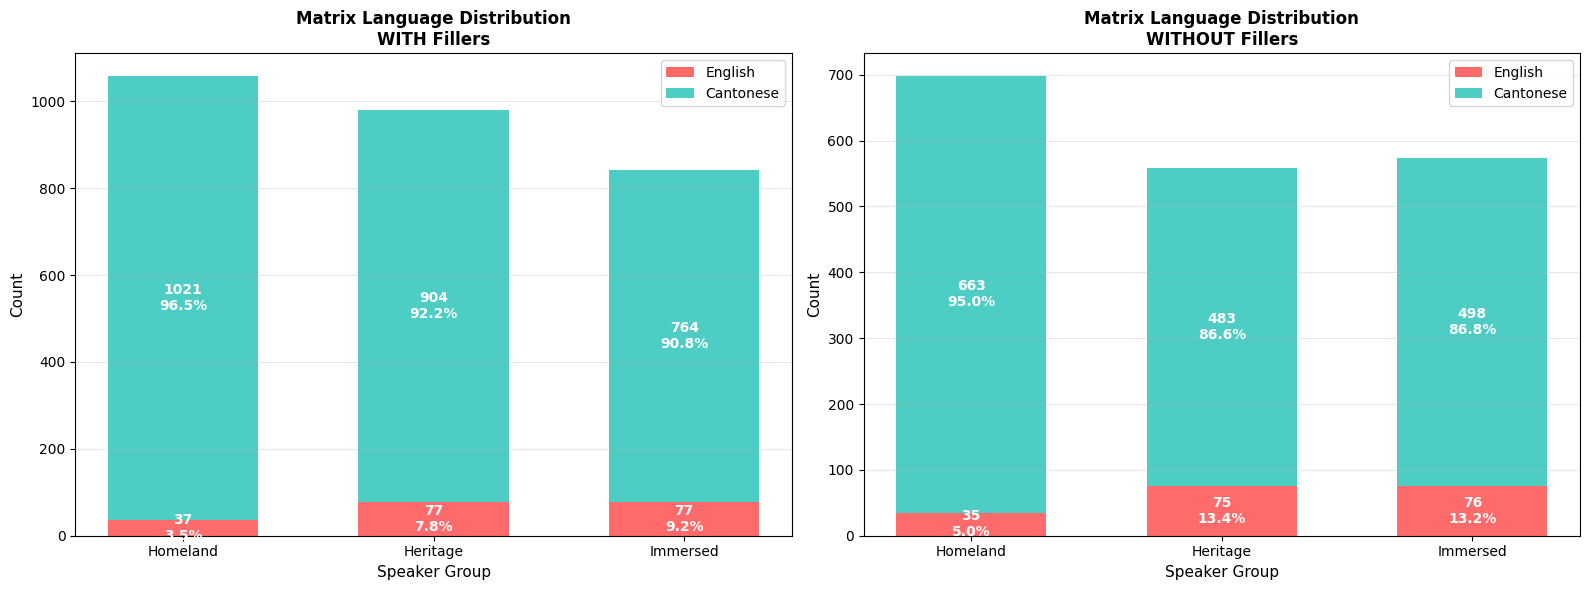


MATRIX LANGUAGE DISTRIBUTION COMPARISON TABLE

WITH Fillers:
Group        Total    Cantonese            English             
----------------------------------------------------------------------
Homeland     1076     1021  ( 94.9%)  37    (  3.4%)
Heritage     1007     904   ( 89.8%)  77    (  7.6%)
Immersed     868      764   ( 88.0%)  77    (  8.9%)

WITHOUT Fillers:
Group        Total    Cantonese            English             
----------------------------------------------------------------------
Homeland     715      663   ( 92.7%)  35    (  4.9%)
Heritage     584      483   ( 82.7%)  75    ( 12.8%)
Immersed     600      498   ( 83.0%)  76    ( 12.7%)

IMPACT OF FILLER REMOVAL
Homeland:
  Cantonese matrix WITH fillers: 94.9%
  Cantonese matrix WITHOUT fillers: 92.7%
  Change: -2.2 percentage points

Heritage:
  Cantonese matrix WITH fillers: 89.8%
  Cantonese matrix WITHOUT fillers: 82.7%
  Change: -7.1 percentage points

Immersed:
  Cantonese matrix WITH fillers: 88.0%
  Canto

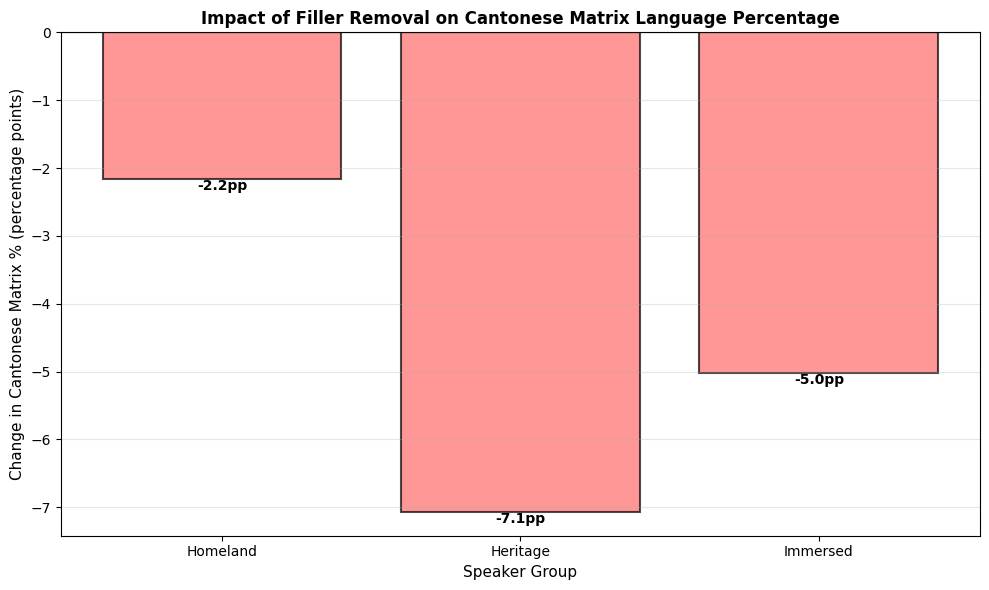

In [164]:
# Prepare data for both datasets
groups = ['Homeland', 'Heritage', 'Immersed']
datasets = [
    ("WITH Fillers", with_fillers),
    ("WITHOUT Fillers", without_fillers)
]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

for ax, (dataset_name, dataset) in zip([ax1, ax2], datasets):
    # Prepare counts for this dataset
    cantonese_counts = []
    english_counts = []

    for group in groups:
        group_sentences = [s for s in dataset if s['group'] == group]
        cant_matrix = sum(1 for s in group_sentences if s['matrix_language'] == 'Cantonese')
        eng_matrix = sum(1 for s in group_sentences if s['matrix_language'] == 'English')
        cantonese_counts.append(cant_matrix)
        english_counts.append(eng_matrix)

    # Create stacked bar chart
    x = np.arange(len(groups))
    width = 0.6

    p1 = ax.bar(x, english_counts, width, label='English', color='#FF6B6B')
    p2 = ax.bar(x, cantonese_counts, width, bottom=english_counts, label='Cantonese', color='#4ECDC4')

    # Labels and formatting
    ax.set_ylabel('Count', fontsize=11)
    ax.set_xlabel('Speaker Group', fontsize=11)
    ax.set_title(f'Matrix Language Distribution\n{dataset_name}',
                 fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)

    # Add percentage labels on bars
    for i, group in enumerate(groups):
        total = cantonese_counts[i] + english_counts[i]

        if total > 0:  # Avoid division by zero
            # English percentage (bottom section)
            eng_pct = english_counts[i] / total * 100
            if english_counts[i] > 30:  # Only show label if bar is big enough
                ax.text(i, english_counts[i]/2, f'{english_counts[i]}\n{eng_pct:.1f}%',
                       ha='center', va='center', fontweight='bold', color='white', fontsize=10)

            # Cantonese percentage (top section)
            cant_pct = cantonese_counts[i] / total * 100
            if cantonese_counts[i] > 30:  # Only show label if bar is big enough
                ax.text(i, english_counts[i] + cantonese_counts[i]/2,
                       f'{cantonese_counts[i]}\n{cant_pct:.1f}%',
                       ha='center', va='center', fontweight='bold', color='white', fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed comparison table
print("\n" + "="*80)
print("MATRIX LANGUAGE DISTRIBUTION COMPARISON TABLE")
print("="*80)

for dataset_name, dataset in datasets:
    print(f"\n{dataset_name}:")
    print(f"{'Group':<12} {'Total':<8} {'Cantonese':<20} {'English':<20}")
    print("-"*70)

    for group in groups:
        group_sentences = [s for s in dataset if s['group'] == group]
        if group_sentences:
            total = len(group_sentences)
            cant_count = sum(1 for s in group_sentences if s['matrix_language'] == 'Cantonese')
            eng_count = sum(1 for s in group_sentences if s['matrix_language'] == 'English')

            print(f"{group:<12} {total:<8} {cant_count:<5} ({cant_count/total*100:>5.1f}%)  "
                  f"{eng_count:<5} ({eng_count/total*100:>5.1f}%)")

# Additional visualization: Impact of filler removal
print("\n" + "="*80)
print("IMPACT OF FILLER REMOVAL")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the change in Cantonese matrix percentage for each group
changes = []
for group in groups:
    # WITH fillers
    with_group = [s for s in with_fillers if s['group'] == group]
    with_cant_pct = sum(1 for s in with_group if s['matrix_language'] == 'Cantonese') / len(with_group) * 100 if with_group else 0

    # WITHOUT fillers
    without_group = [s for s in without_fillers if s['group'] == group]
    without_cant_pct = sum(1 for s in without_group if s['matrix_language'] == 'Cantonese') / len(without_group) * 100 if without_group else 0

    change = without_cant_pct - with_cant_pct
    changes.append(change)

    print(f"{group}:")
    print(f"  Cantonese matrix WITH fillers: {with_cant_pct:.1f}%")
    print(f"  Cantonese matrix WITHOUT fillers: {without_cant_pct:.1f}%")
    print(f"  Change: {change:+.1f} percentage points\n")

# Plot the changes
x = np.arange(len(groups))
colors = ['#FF6B6B' if c < 0 else '#4ECDC4' for c in changes]
bars = ax.bar(x, changes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_ylabel('Change in Cantonese Matrix % (percentage points)', fontsize=11)
ax.set_xlabel('Speaker Group', fontsize=11)
ax.set_title('Impact of Filler Removal on Cantonese Matrix Language Percentage',
             fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(groups)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, change) in enumerate(zip(bars, changes)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{change:+.1f}pp',
            ha='center', va='bottom' if height > 0 else 'top',
            fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Equal Matrix Analysis


COMPLETE MATRIX LANGUAGE DISTRIBUTION (Including Equal Cases)

WITH Fillers:
Group        Total    Cantonese       English         Equal          
--------------------------------------------------------------------------------
Homeland     1076     1021  ( 94.9%)  37    (  3.4%)  17    (  1.6%)
Heritage     1007     904   ( 89.8%)  77    (  7.6%)  26    (  2.6%)
Immersed     868      764   ( 88.0%)  77    (  8.9%)  26    (  3.0%)

WITHOUT Fillers:
Group        Total    Cantonese       English         Equal          
--------------------------------------------------------------------------------
Homeland     715      663   ( 92.7%)  35    (  4.9%)  17    (  2.4%)
Heritage     584      483   ( 82.7%)  75    ( 12.8%)  26    (  4.5%)
Immersed     600      498   ( 83.0%)  76    ( 12.7%)  26    (  4.3%)


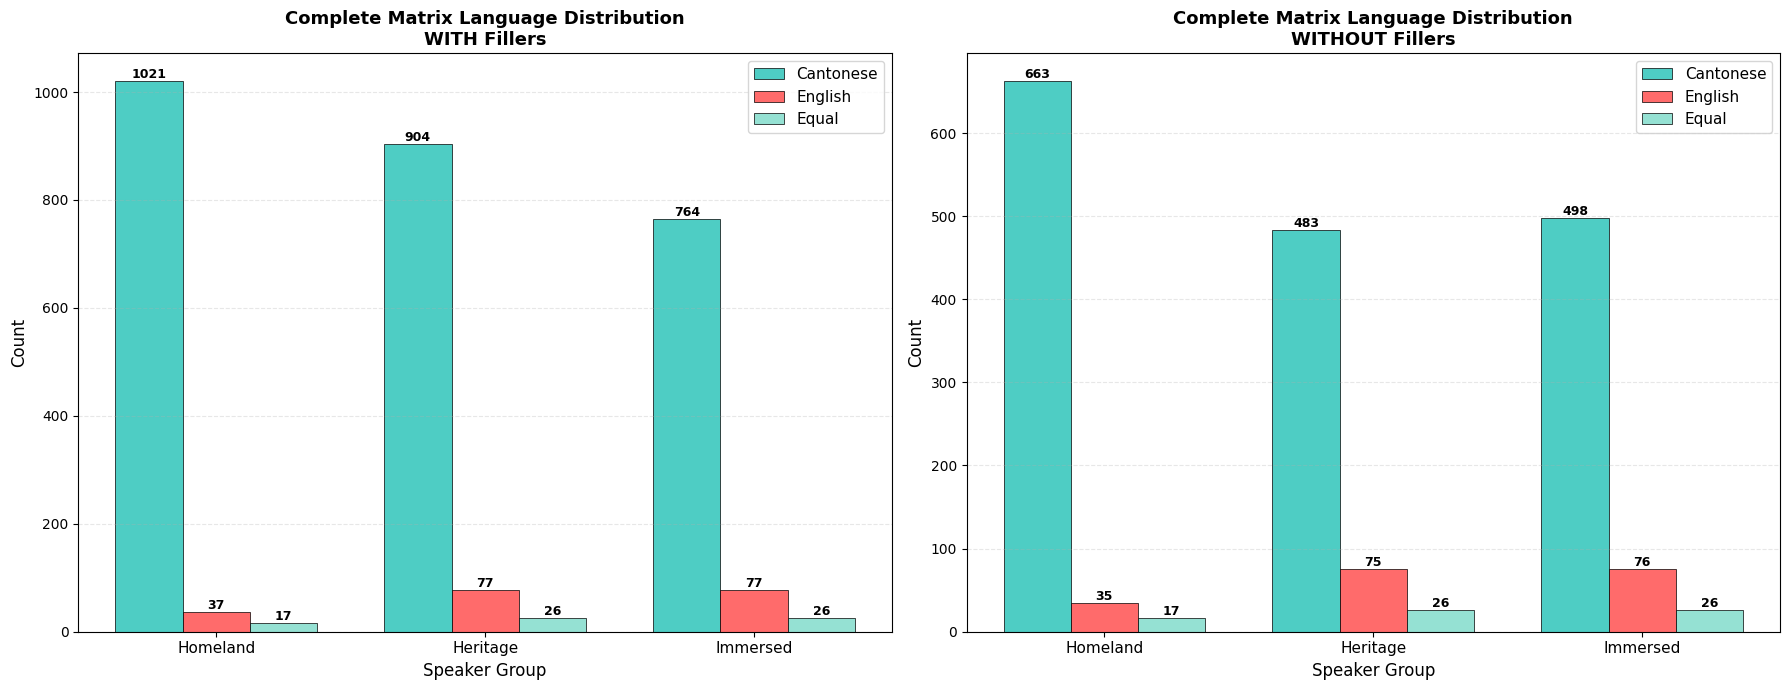


EQUAL MATRIX LANGUAGE CASES - DETAILED ANALYSIS

WITH Fillers:
  Total Equal cases: 69 out of 2951 (2.34%)
    Homeland: 17 out of 1076 (1.58%)
    Heritage: 26 out of 1007 (2.58%)
    Immersed: 26 out of 868 (3.00%)

  Sample Equal matrix sentences:
    1. [Homeland] Pattern: C1-E1
       Text: eh 讀緊 linguistics...
       Cantonese words: 1, English words: 2
    2. [Homeland] Pattern: E1-C1
       Text: uh huh 無...
       Cantonese words: 1, English words: 2
    3. [Homeland] Pattern: C2-E2
       Text: 而家 讀緊 mechanical engineering...
       Cantonese words: 2, English words: 2

WITHOUT Fillers:
  Total Equal cases: 69 out of 1899 (3.63%)
    Homeland: 17 out of 715 (2.38%)
    Heritage: 26 out of 584 (4.45%)
    Immersed: 26 out of 600 (4.33%)

  Sample Equal matrix sentences:
    1. [Homeland] Pattern: C1-E1
       Text: eh 讀緊 linguistics...
       Cantonese words: 1, English words: 2
    2. [Homeland] Pattern: E1-C1
       Text: uh huh 無...
       Cantonese words: 1, English words

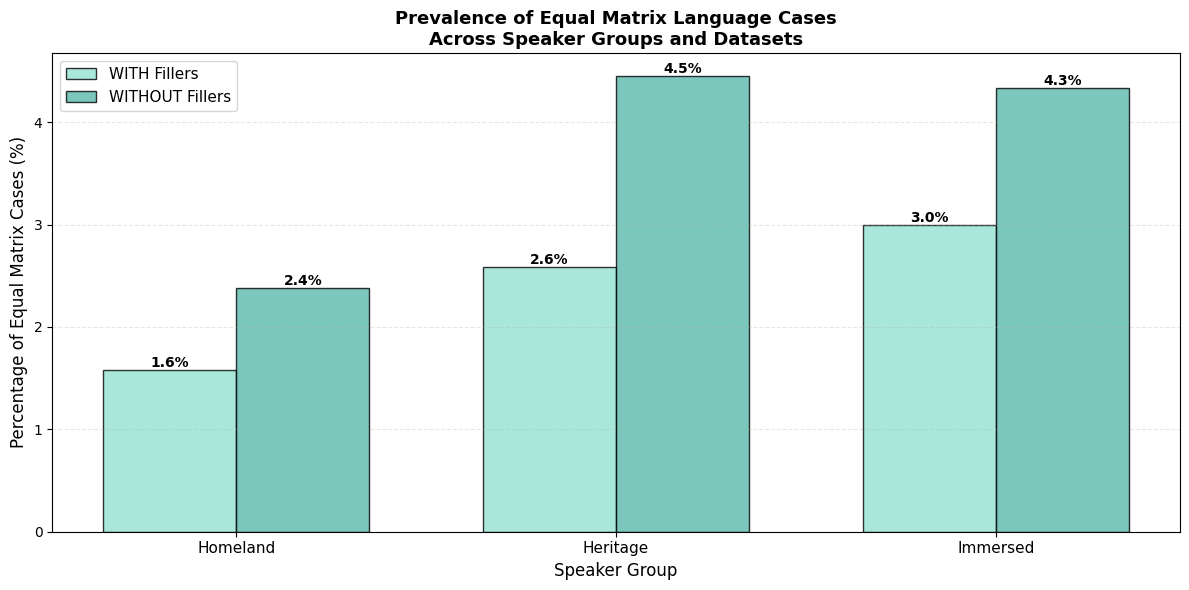

In [165]:
# Visualization for ALL matrix language categories including "Equal"
print("\n" + "="*80)
print("COMPLETE MATRIX LANGUAGE DISTRIBUTION (Including Equal Cases)")
print("="*80)

# First, let's get detailed counts for all three categories
for dataset_name, dataset in datasets:
    print(f"\n{dataset_name}:")
    print(f"{'Group':<12} {'Total':<8} {'Cantonese':<15} {'English':<15} {'Equal':<15}")
    print("-"*80)

    for group in groups:
        group_sentences = [s for s in dataset if s['group'] == group]
        if group_sentences:
            total = len(group_sentences)
            cant_count = sum(1 for s in group_sentences if s['matrix_language'] == 'Cantonese')
            eng_count = sum(1 for s in group_sentences if s['matrix_language'] == 'English')
            equal_count = sum(1 for s in group_sentences if s['matrix_language'] == 'Equal')

            print(f"{group:<12} {total:<8} {cant_count:<5} ({cant_count/total*100:>5.1f}%)  "
                  f"{eng_count:<5} ({eng_count/total*100:>5.1f}%)  "
                  f"{equal_count:<5} ({equal_count/total*100:>5.1f}%)")

# Create visualization with grouped bars showing all three categories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

for ax, (dataset_name, dataset) in zip([ax1, ax2], datasets):
    # Prepare counts for all three matrix language types
    cantonese_counts = []
    english_counts = []
    equal_counts = []

    for group in groups:
        group_sentences = [s for s in dataset if s['group'] == group]
        cant_count = sum(1 for s in group_sentences if s['matrix_language'] == 'Cantonese')
        eng_count = sum(1 for s in group_sentences if s['matrix_language'] == 'English')
        equal_count = sum(1 for s in group_sentences if s['matrix_language'] == 'Equal')

        cantonese_counts.append(cant_count)
        english_counts.append(eng_count)
        equal_counts.append(equal_count)

    # Create grouped bar chart with three bars per group
    x = np.arange(len(groups))
    width = 0.25  # Width of each bar

    # Position bars side by side
    bars1 = ax.bar(x - width, cantonese_counts, width, label='Cantonese',
                   color='#4ECDC4', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, english_counts, width, label='English',
                   color='#FF6B6B', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, equal_counts, width, label='Equal',
                   color='#95E1D3', edgecolor='black', linewidth=0.5)

    # Labels and formatting
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('Speaker Group', fontsize=12)
    ax.set_title(f'Complete Matrix Language Distribution\n{dataset_name}',
                 fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=11)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add count labels on top of each bar
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:  # Only show label if there's a count
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: Focus specifically on Equal cases
print("\n" + "="*80)
print("EQUAL MATRIX LANGUAGE CASES - DETAILED ANALYSIS")
print("="*80)

for dataset_name, dataset in datasets:
    equal_sentences = [s for s in dataset if s['matrix_language'] == 'Equal']
    total_sentences = len(dataset)

    print(f"\n{dataset_name}:")
    print(f"  Total Equal cases: {len(equal_sentences)} out of {total_sentences} "
          f"({len(equal_sentences)/total_sentences*100:.2f}%)")

    # Breakdown by group
    for group in groups:
        group_equal = [s for s in equal_sentences if s['group'] == group]
        group_total = [s for s in dataset if s['group'] == group]
        if group_total:
            print(f"    {group}: {len(group_equal)} out of {len(group_total)} "
                  f"({len(group_equal)/len(group_total)*100:.2f}%)")

    # Show some examples of Equal cases
    if equal_sentences:
        print(f"\n  Sample Equal matrix sentences:")
        for i, sent in enumerate(equal_sentences[:3], 1):
            print(f"    {i}. [{sent['group']}] Pattern: {sent['pattern']}")
            print(f"       Text: {sent['reconstructed_text'][:80]}...")
            print(f"       Cantonese words: {sent['cant_words']}, English words: {sent['eng_words']}")

# Create a focused visualization comparing Equal cases across groups
fig, ax = plt.subplots(figsize=(12, 6))

equal_percentages_with = []
equal_percentages_without = []

for group in groups:
    # WITH fillers
    with_group = [s for s in with_fillers if s['group'] == group]
    with_equal_count = sum(1 for s in with_group if s['matrix_language'] == 'Equal')
    with_equal_pct = (with_equal_count / len(with_group) * 100) if with_group else 0
    equal_percentages_with.append(with_equal_pct)

    # WITHOUT fillers
    without_group = [s for s in without_fillers if s['group'] == group]
    without_equal_count = sum(1 for s in without_group if s['matrix_language'] == 'Equal')
    without_equal_pct = (without_equal_count / len(without_group) * 100) if without_group else 0
    equal_percentages_without.append(without_equal_pct)

# Create grouped bar chart
x = np.arange(len(groups))
width = 0.35

bars1 = ax.bar(x - width/2, equal_percentages_with, width, label='WITH Fillers',
               color='#95E1D3', edgecolor='black', linewidth=1, alpha=0.8)
bars2 = ax.bar(x + width/2, equal_percentages_without, width, label='WITHOUT Fillers',
               color='#5AB9AC', edgecolor='black', linewidth=1, alpha=0.8)

# Labels and formatting
ax.set_ylabel('Percentage of Equal Matrix Cases (%)', fontsize=12)
ax.set_xlabel('Speaker Group', fontsize=12)
ax.set_title('Prevalence of Equal Matrix Language Cases\nAcross Speaker Groups and Datasets',
             fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(groups, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add percentage labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()